In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('credit_batch_1.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,isFraud
0,88672.0,-3.859881,2.632881,-5.264265,3.446113,-0.675231,-1.904959,-3.291041,-0.985766,-1.168114,...,1.664119,0.785075,0.068412,0.778961,-0.863166,-0.006810,-1.065734,1.773326,1.18,1
1,62059.0,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,-2.809071,...,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,6.62,1
2,13323.0,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,-6.329801,...,1.846165,-0.267172,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,1.00,1
3,93965.0,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,...,0.339007,1.342923,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,11.40,1
4,52934.0,1.036639,0.407227,0.757706,3.161821,-0.568122,0.202181,-0.689804,0.411380,0.336769,...,-0.050108,0.123761,-0.132568,0.350231,0.507701,0.189621,0.061016,0.063141,0.76,1


In [3]:
data['isFraud'].value_counts()

isFraud
0    8000
1     490
Name: count, dtype: int64

## Split Dataset

In [4]:
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

#Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [5]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(random_state=75).fit_resample(X_train, y_train)

pd.Series(y_train).value_counts()

isFraud
0    6398
1    6398
Name: count, dtype: int64

## Define TF Model Layers

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

2023-05-04 00:49:27.191986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# DNN
model = Sequential([
Dense(input_dim = 30, units = 128, activation = "relu"),
Dense(units= 64, activation = "relu"),
Dropout(0.2),
Dense(units= 32, activation = "relu"),
Dropout(0.2),
Dense(units= 16, activation = "relu"),
Dropout(0.2),
Dense(units=1, activation = "sigmoid")])

In [8]:
# Add training callbacks
from keras.callbacks import LambdaCallback, Callback

current_epoch = 0
current_weights = None
current_loss = None
current_accuracy = None

def update_current_epoch():
    global current_epoch
    current_epoch += 1
    
def update_current_weights():
    global current_weights
    current_weights = model.layers[0].get_weights()
    
def update_current_performance(loss, accuracy):
    global current_loss, current_accuracy
    current_loss = loss
    current_accuracy = accuracy

class CustomCallback(Callback):

    def on_epoch_end(self, batch, logs=None):
        update_current_epoch()
        update_current_weights()
        update_current_performance(logs['loss'], logs['accuracy'])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

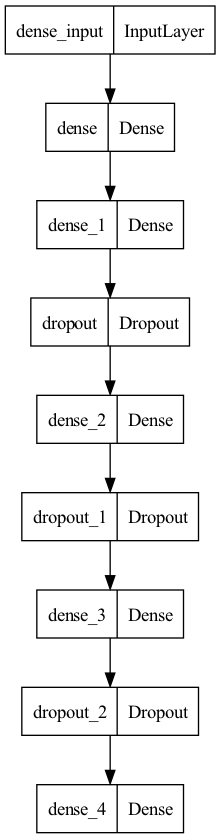

In [9]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(model)

## Model Training

In [10]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

model.fit(X_train, y_train, epochs=50, batch_size=100, callbacks = [CustomCallback()])

Epoch 1/50
128/128 [==============================] - 1s 989us/step - loss: 0.2087 - accuracy: 0.9199
Epoch 2/50
128/128 [==============================] - 0s 942us/step - loss: 0.0905 - accuracy: 0.9682
Epoch 3/50
128/128 [==============================] - 0s 941us/step - loss: 0.0570 - accuracy: 0.9805
Epoch 4/50
128/128 [==============================] - 0s 937us/step - loss: 0.0354 - accuracy: 0.9884
Epoch 5/50
128/128 [==============================] - 0s 893us/step - loss: 0.0231 - accuracy: 0.9934
Epoch 6/50
128/128 [==============================] - 0s 905us/step - loss: 0.0147 - accuracy: 0.9955
Epoch 7/50
128/128 [==============================] - 0s 883us/step - loss: 0.0186 - accuracy: 0.9946
Epoch 8/50
128/128 [==============================] - 0s 968us/step - loss: 0.0098 - accuracy: 0.9973
Epoch 9/50
128/128 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9969
Epoch 10/50
128/128 [==============================] - 0s 1ms/step - loss: 0.0058 - 

## Model Evaluation

In [11]:
y_hat = model.predict(X_test)
y_hat = [0 if val < 0.5 else 1 for val in y_hat]

54/54 [==============================] - 0s 553us/step


In [12]:
accuracy_score(y_test, y_hat)

0.9893992932862191

In [13]:
model.evaluate(X_test, y_test)

54/54 [==============================] - 0s 680us/step - loss: 0.2398 - accuracy: 0.9894


[0.23977497220039368, 0.9893993139266968]

## Save Model

In [14]:
# model.save('pretrained_model')

In [15]:
# # Load model
# del model
# model = load_model('pretrained_model')

## Check Updated Local States

In [16]:
def check_local_state():
    print("Current epoch:", current_epoch)
    print("Current weights:", current_weights)
    print("Current loss: {}, accuracy: {}".format(current_loss, current_accuracy))

In [17]:
check_local_state()

Current epoch: 50
Current weights: [array([[ 0.15431066,  0.12361097, -0.01848336, ...,  0.20996231,
        -0.12576202,  0.2220981 ],
       [-0.19598782,  0.08777609, -0.02627608, ...,  0.25590143,
        -0.36792332, -0.06249547],
       [ 0.22722156, -0.22586308,  0.09418079, ...,  0.00161112,
         0.20652501, -0.16950078],
       ...,
       [-0.11819647, -0.04367141,  0.11831068, ..., -0.21230078,
         0.16099764, -0.17520204],
       [ 0.3025069 ,  0.11962485,  0.05586259, ...,  0.18774629,
         0.00890966,  0.01046886],
       [-0.10197764, -0.05634901, -0.07621078, ...,  0.0689083 ,
         0.1714542 ,  0.0376121 ]], dtype=float32), array([-0.01350128,  0.07503058, -0.10688986, -0.03848607, -0.04753429,
       -0.01081146, -0.14980137, -0.09135803,  0.04938711, -0.14910673,
       -0.1472885 , -0.10549573, -0.01357349,  0.0176871 , -0.09908132,
        0.04127047, -0.05462746, -0.16739197, -0.06805372, -0.03679273,
        0.01477204, -0.02051158,  0.02737469,  